In [1]:
import os 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import h5py
import numpy as np 


from scipy.integrate import simps
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline
from PIL import Image

sns.set_context("talk")

%matplotlib inline

In [2]:


# Fit the resolution data to a polynomial for extrapolation
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Create a function to get resolution for any energy
def get_resolution(e,popt):
    return np.maximum(poly_func(e, *popt), 1e-10)  # Ensure non-zero resolution


# Perform Gaussian broadening using convolution with energy-dependent widths
def gaussian_broadening(dos, energy, sigmas):
    broadened_dos = np.zeros_like(dos)
    for i in range(len(energy)):
        # Create a Gaussian kernel centered at each energy point with width sigmas[i]
        kernel = np.exp(-0.5 * ((energy - energy[i]) / sigmas[i])**2)
        kernel /= simps(kernel, energy)  # Normalize the kernel to preserve area
        broadened_dos += dos[i] * kernel  # Convolve DOS with Gaussian kernel
    return broadened_dos

def apply_gaussian_broadening(dos_data,metric='dos total (nm2/ps)',unit_cell_atoms=1):
    energy = dos_data['Energy Transfer (meV)'].values
    dos = dos_data[metric].values

    resolution_data = pd.read_csv('../data/experiment/resolution.csv')
    res_energy = resolution_data['Energy (meV)'].values
    resolution = resolution_data['Resolution'].values
    popt, _ = curve_fit(poly_func, res_energy, resolution)
    
    # Create an array of sigmas for Gaussian broadening based on the resolution function
    sigmas = get_resolution(energy,popt) / np.sqrt(8 * np.log(2))  # Convert FWHM to sigma


    broadened_dos = gaussian_broadening(dos, energy, sigmas)

    # Area normalize both original and broadened DOS
    original_area = simps(dos, energy)
    broadened_area = simps(broadened_dos, energy)

    dos_normalized = dos / original_area
    broadened_dos_normalized = broadened_dos / broadened_area
    return 3*unit_cell_atoms*broadened_dos_normalized

In [7]:

results_directory={"../results/gromacs/nanoparticle/2nm/results/md_phonon_200/":("0",200)
                  ,"../results/gromacs/nanoparticle/H2O/2nm/concentration/results/100/md_phonon_200/":("100",200)
                  ,"../results/gromacs/nanoparticle/H2O/2nm/concentration/results/250/md_phonon_200/":("250",200)
                  ,"../results/gromacs/nanoparticle/H2O/2nm/concentration/results/500/md_phonon_200/":("500",200)
                  ,"../results/gromacs/nanoparticle/H2O/2nm/concentration/results/1000/md_phonon_200/":("1000",200)
                  ,"../results/gromacs/H2O/results/md_prod_250/":("bulk",200)
                  ,"../results/gromacs/nanoparticle/2nm/results/md_phonon_300/":("0",300)
                  ,"../results/gromacs/nanoparticle/H2O/2nm/concentration/results/100/md_phonon_300/":("100",300)
                  ,"../results/gromacs/nanoparticle/H2O/2nm/concentration/results/250/md_phonon_300/":("250",300)
                  ,"../results/gromacs/nanoparticle/H2O/2nm/concentration/results/500/md_phonon_300/":("500",300)
                  ,"../results/gromacs/nanoparticle/H2O/2nm/concentration/results/1000/md_phonon_300/":("1000",300)
                   ,"../results/gromacs/H2O/results/md_prod_300/":("bulk",300)
}
df_list=list()

min_energy=1
max_energy=300

for data_directory,(water,temperature) in results_directory.items():
    for filename in os.listdir(data_directory):
        if not "dos.h5" in filename:
            continue
        print(os.path.join(data_directory,filename))
        h5file=h5py.File(os.path.join(data_directory,filename))
        data_dict=dict()
        omega_shape=h5file["omega"][:].shape
        for k in h5file.keys():
            data_array=h5file[k][:]
            if data_array.shape != omega_shape or "_0" in k:
                continue
            units=h5file[k].attrs['units']
            data_dict["%s (%s)"%(k.replace("_"," "),units)]=data_array
        df_tmp=pd.DataFrame(data_dict).query("%f < `omega (rad/ps)` and `omega (rad/ps)` < %f"%(min_energy/0.6582,max_energy/0.6582))
        directory_split=data_directory.split("/")
        system=directory_split[3]
        df_tmp["Temperature (K)"]=temperature
        df_tmp["H2O"]=water
        df_tmp["Weight"]=" ".join(filename.split("_")[:-1]).replace('b ','').capitalize()
        df_tmp["Method"]="GROMACS"
        df_tmp["Force Field"]="LJ"
        df_tmp["Energy Transfer (meV)"]=df_tmp["omega (rad/ps)"]*0.6582
        df_tmp["Normalized Count"]=apply_gaussian_broadening(df_tmp,unit_cell_atoms=137)
        for species in ["Fe","O","H"]:
            if (species == "H" and water =="0") or (species == "Fe" and water == "bulk") :
                continue
            df_tmp[species]=apply_gaussian_broadening(df_tmp,"dos %s (nm2/ps)"%species)
            df_tmp["Max Normalized %s"%species]=df_tmp[species]/df_tmp.query("`Energy Transfer (meV)` > 5")[species].max()
        df_tmp["Max Normalized Count"]=df_tmp["Normalized Count"]/df_tmp.query("`Energy Transfer (meV)` > 5")["Normalized Count"].max()        
        df_tmp["Software"]=directory_split[2]
        df_tmp["System"]=system #.split("_")[0].replace("nanoparticle", "np")
        
        df_list.append(df_tmp)
        
df_dos_gromacs=pd.concat(df_list,ignore_index=True)

../results/gromacs/nanoparticle/2nm/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/2nm/results/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/concentration/results/100/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/concentration/results/100/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/concentration/results/250/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/concentration/results/250/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/concentration/results/500/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/concentration/results/500/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/concentration/results/1000/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/H2O/2nm/concentration/results/1000/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/H2O/results/md_prod_250/b_coheren

In [8]:
results_directory={"../results/lammps/nanoparticle/2nm/reaxff2022/results/mdanse/":"0"
                  ,"../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/100/mdanse/":"100"
                  ,"../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/250/mdanse/":"250"
                  ,"../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/500/mdanse/":"500"
                  ,"../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/1000/mdanse/":"1000"
                  ,"../results/lammps/H2O/reaxff2022/results/mdanse/":"bulk"
                  }
df_list=list()


for data_directory,water in results_directory.items():
    for filename in os.listdir(data_directory):
        if not "dos.h5" in filename:
            continue
        print(os.path.join(data_directory,filename))
        h5file=h5py.File(os.path.join(data_directory,filename))
        data_dict=dict()
        omega_shape=h5file["omega"][:].shape
        for k in h5file.keys():
            data_array=h5file[k][:]
            if data_array.shape != omega_shape or "_0" in k:
                continue
            units=h5file[k].attrs['units']
            data_dict["%s (%s)"%(k.replace("_"," "),units)]=data_array
        df_tmp=pd.DataFrame(data_dict).query("%f < `omega (rad/ps)` and `omega (rad/ps)` < %f"%(min_energy/0.6582,max_energy/0.6582))
        directory_split=data_directory.split("/")
        system=directory_split[3]
        tt=int(filename.split("_")[-2].replace("K",""))
        df_tmp["Temperature (K)"]=tt if tt!=250 else 200
        df_tmp["H2O"]=water
        df_tmp["Weight"]=None
        if "b_coherent" in filename:
            df_tmp["Weight"]="Coherent" 
        elif "b_incoherent" in filename:
            df_tmp["Weight"]="Incoherent"
        df_tmp["Energy Transfer (meV)"]=df_tmp["omega (rad/ps)"]*0.6582
        df_tmp["Normalized Count"]=apply_gaussian_broadening(df_tmp,unit_cell_atoms=137)
        for species in ["Fe","O","H"]:
            if (species == "H" and water =="0") or (species == "Fe" and water == "bulk") :
                continue
            df_tmp[species]=apply_gaussian_broadening(df_tmp,"dos %s (nm2/ps)"%species)
            df_tmp["Max Normalized %s"%species]=df_tmp[species]/df_tmp.query("`Energy Transfer (meV)` > 5")[species].max()
        df_tmp["Max Normalized Count"]=df_tmp["Normalized Count"]/df_tmp.query("`Energy Transfer (meV)` > 5")["Normalized Count"].max()        
        df_tmp["Software"]=directory_split[2]
        df_tmp["System"]=system #.split("_")[0].replace("nanoparticle", "np")
        df_tmp["Force Field"]="ReaxFF2022"
        df_list.append(df_tmp)
        
df_dos_lammps=pd.concat(df_list,ignore_index=True)

../results/lammps/nanoparticle/2nm/reaxff2022/results/mdanse/b_coherent_200K_dos.h5
../results/lammps/nanoparticle/2nm/reaxff2022/results/mdanse/b_coherent_300K_dos.h5
../results/lammps/nanoparticle/2nm/reaxff2022/results/mdanse/b_incoherent_200K_dos.h5
../results/lammps/nanoparticle/2nm/reaxff2022/results/mdanse/b_incoherent_300K_dos.h5
../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/100/mdanse/nvt_phonon_b_coherent_200K_dos.h5
../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/100/mdanse/nvt_phonon_b_coherent_300K_dos.h5
../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/100/mdanse/nvt_phonon_b_incoherent_200K_dos.h5
../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/100/mdanse/nvt_phonon_b_incoherent_300K_dos.h5
../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/250/mdanse/nvt_phonon_b_coherent_200K_dos.h5
../results/lammps/nanoparticle/H2O/2nm/reaxff2022/results/250/mdanse/nvt_phonon_b_coherent_300K_dos.h5
../results/lammps/nanoparticle/H2O/2nm

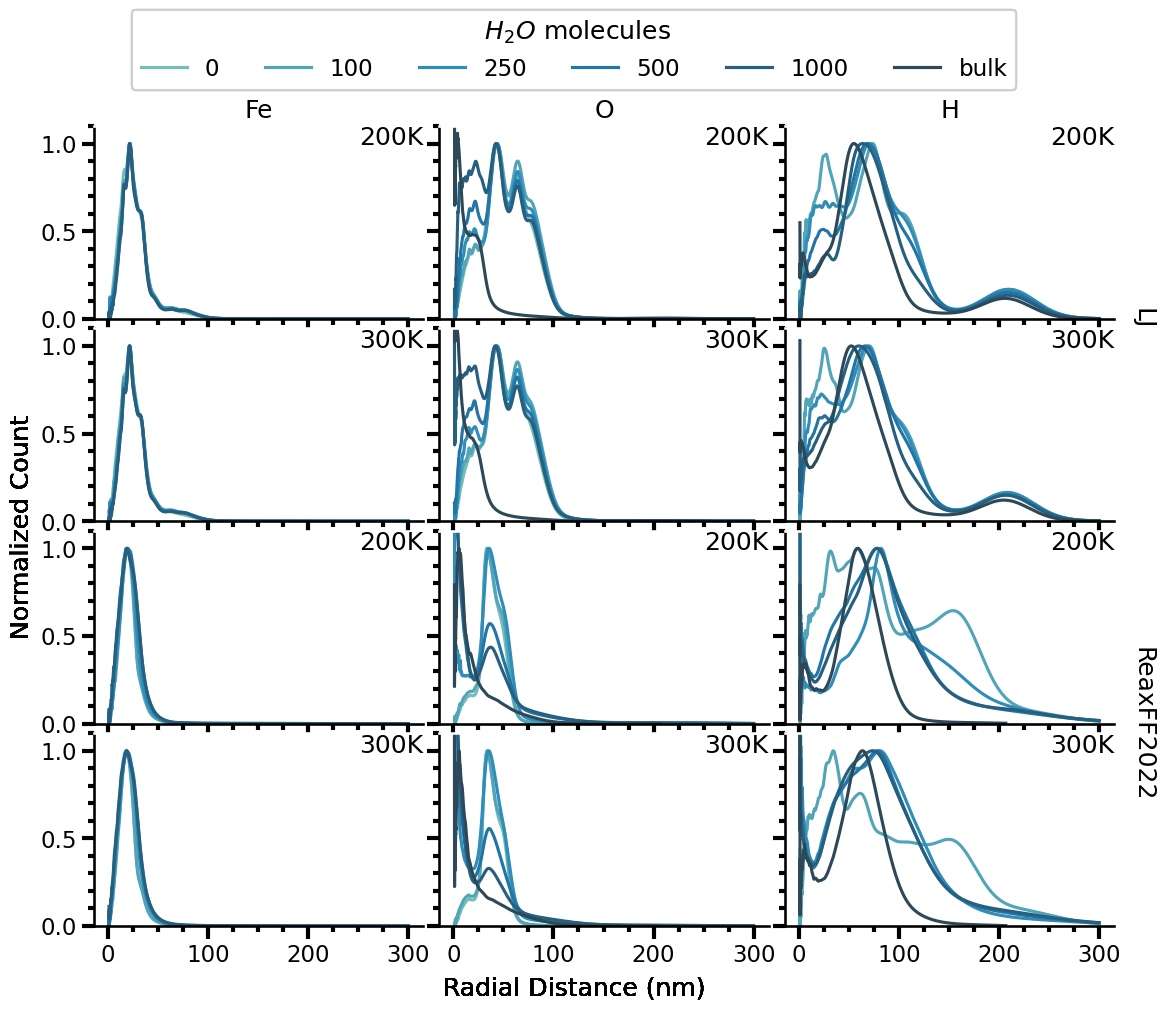

In [11]:


df_dos=pd.concat([df_dos_gromacs,df_dos_lammps],ignore_index=True)

temperature_list=df_dos["Temperature (K)"].unique()
len_temperature_list=len(temperature_list)
force_field_list=df_dos["Force Field"].unique()
len_force_field_list=len(force_field_list)
H2O_molecules_list=df_dos["H2O"].unique()
species_list=["Fe","O","H"]
len_species_list=len(species_list)

fig, axs = plt.subplots(ncols=len_species_list,nrows=len_force_field_list+len_temperature_list,figsize=(4*len_species_list,2.5*(len_force_field_list+len_temperature_list))
                       # ,height_ratios =(3,2)
                       )
sns.set_context("talk")

emin,emax=1,300


labx=1
laby=1
index_label=list("abcdefghijklmn")
for i,temperature in enumerate(temperature_list):
    for j,forcefield in enumerate(force_field_list):
        for k,specie in enumerate(species_list):

            ax=axs[i+len_temperature_list*j,k]
            ax.text(labx, laby, "%dK"%temperature ,transform=ax.transAxes,ha="right",va="top")

            sns.lineplot(data=df_dos.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and `Temperature (K)` == %d and `Force Field` == '%s' and Weight == '%s' "%(emin,emax,temperature,forcefield,"Incoherent"))
                                ,y="Max Normalized %s"%specie
                                ,x='Energy Transfer (meV)'
                                ,hue="H2O"
            #                    ,hue_order=["0","100","250","500","1000","bulk"]
                                 ,ax=ax
                                 ,palette="YlGnBu_d"
                                 ,legend=i*j*k==0
                           )

            ax.spines['bottom'].set_color('0')
            ax.spines['top'].set_color('1')
            ax.spines['right'].set_color('1')
            ax.spines['left'].set_color('0')
            ax.tick_params(direction='out', width=3, bottom=True, left=True)
            ax.grid(False)
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.set_ylim(0,1.1)
            if j+len_force_field_list*i==0:
                ax.set_title(specie)
            if i*j*k==0:
                sns.move_legend(ax,'lower center',bbox_to_anchor=(0.5,0.925)
                               ,bbox_transform=fig.transFigure,ncol=6,title=" $H_2O$ molecules"
                               )
            if j+i != len_force_field_list+len_temperature_list-2:
                ax.set_xticklabels([])
            if k > 0:
                ax.set_yticklabels([])

            if i*j*k==0:
                ax.text(0.5, 0.05, 'Radial Distance (nm)' ,transform=fig.transFigure,ha="center",va="top")
                ax.text(0.05, 0.5, 'Normalized Count' ,transform=fig.transFigure,ha="right",va="center",rotation="vertical")
            if k == len_species_list-1 and i==0:
                ax.text(1.05, 0, forcefield ,transform=ax.transAxes,ha="left",va="center",rotation=-90)
            ax.xaxis.set_minor_locator(MultipleLocator(100/4))
            ax.yaxis.set_minor_locator(MultipleLocator(0.1))
            ax.tick_params(which='minor', length=4,width=3)
            
#            ax.tick_params(axis='x', which='minor', bottom=False)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0.05, 
                    hspace=0.05
                   )

plt.savefig("../figures/figC2.pdf"%temperature, pad_inches=0.2,bbox_inches="tight")